In [1]:
using MKL
using PhysicalUnits, LinearAlgebra
using MoireIVC.LLHF
using MoireIVC.LLHF_Plot
using MoireIVC.LLTDHF
using CairoMakie
CairoMakie.activate!()
Threads.nthreads()

8

In [2]:
Sys.cpu_info()

8-element Vector{Base.Sys.CPUinfo}:
 Base.Sys.CPUinfo("Intel(R) Core(TM) i5-1035G4 CPU @ 1.10GHz", 1498, 0x000000000009f948, 0x0000000000000000, 0x000000000007e0b9, 0x000000000034c8d1, 0x0000000000011e7f)
 Base.Sys.CPUinfo("Intel(R) Core(TM) i5-1035G4 CPU @ 1.10GHz", 1498, 0x00000000000952d7, 0x0000000000000000, 0x000000000005a7b1, 0x000000000037a6c3, 0x0000000000002d97)
 Base.Sys.CPUinfo("Intel(R) Core(TM) i5-1035G4 CPU @ 1.10GHz", 1498, 0x00000000000c06ac, 0x0000000000000000, 0x0000000000079efd, 0x000000000032fba2, 0x0000000000007bf6)
 Base.Sys.CPUinfo("Intel(R) Core(TM) i5-1035G4 CPU @ 1.10GHz", 1498, 0x00000000000ac504, 0x0000000000000000, 0x0000000000056a3b, 0x000000000036720c, 0x00000000000038f2)
 Base.Sys.CPUinfo("Intel(R) Core(TM) i5-1035G4 CPU @ 1.10GHz", 1498, 0x00000000000cacb0, 0x0000000000000000, 0x000000000006b1fd, 0x000000000033429e, 0x0000000000004d83)
 Base.Sys.CPUinfo("Intel(R) Core(TM) i5-1035G4 CPU @ 1.10GHz", 1498, 0x00000000000c11e7, 0x0000000000000000, 0x00000000

In [6]:
@show LLHF.define_MoTe2system().B
AVL_sys = LLHF.LLHFSysPara(
    ϵ = 4, 
    a_Moire = 0.352nm/2.0/sind(2.1/2.0) / sqrt(2.0), 
    D = 20nm,
    ratio12 = sqrt(3.0),
    cosθ = 0.0,
    sinθ = 1.0,
)
@show AVL_sys;

(LLHF.define_MoTe2system()).B = 0.0020726748066780807
AVL_sys = MoireIVC.LLHF.LLHFSysPara(37.947, 0.0052492, 4.0, 6.7913374843684045, 1.7320508075688772, 0.0, 1.0, 26.62870201326543, 20.0, 2.0586620785190313, 0.006218024420034243, 44.95073014307693, 174.86779690864748, [6.7913374843684045, -0.0], [0.0, 3.9209805247576943], 0.9251764209394056, [0.9251764209394056, 0.0], [0.0, 1.6024525670317809], 1.904625613727915, -4.423757977113575 + 0.0im, 4.4691389092876355)


In [29]:
N1 = 20; N2 = 34;
num_para = LLHF_init_with_lambda(0.0, AVL_sys; 
    N1 = N1, N2 = N2, LL = 0
);
num_para.H0 .= 0.0;

In [30]:
sym = [LLHF.Trans(1,1); LLHF.PT(0,:PT)];
ρ_AVL = LLHF_solve(num_para; coherence = 0.0, 
    error_tolerance = 1E-10, max_iter_times = 100, 
    post_process_times = 100, post_procession = sym,
    complusive_mixing=false, complusive_mixing_rate=0.5, 
    stepwise_output = true, final_output = true
);

1 	 DM error:0.6725241987655688 	 E/S:-0.7847644477148734
update rate = 0.5: unstable solution with higher energy
2 	 DM error:0.406637911579735 	 E/S:-0.19752440310617173
update rate = 0.5: unstable solution with higher energy
3 	 DM error:0.38596644577613054 	 E/S:-0.053201837209873544
update rate = 1.0: unstable solution with lower energy
4 	 DM error:0.5028315239185981 	 E/S:-0.06953628847506461
update rate = 1.0: unstable solution with lower energy
5 	 DM error:0.1687366154222265 	 E/S:-1.237858394111617
update rate = 1.0: unstable solution with lower energy
6 	 DM error:0.03508790442504988 	 E/S:-1.2647864738656658
update rate = 1.0: unstable solution with lower energy
7 	 DM error:0.008556975625125592 	 E/S:-1.266651141068142
update rate = 1.0: unstable solution with lower energy
8 	 DM error:0.002141677140923276 	 E/S:-1.2667806770167263
update rate = 1.0: unstable solution with lower energy
9 	 DM error:0.0005483189387344169 	 E/S:-1.2667897225573328
update rate = 1.0: unstabl

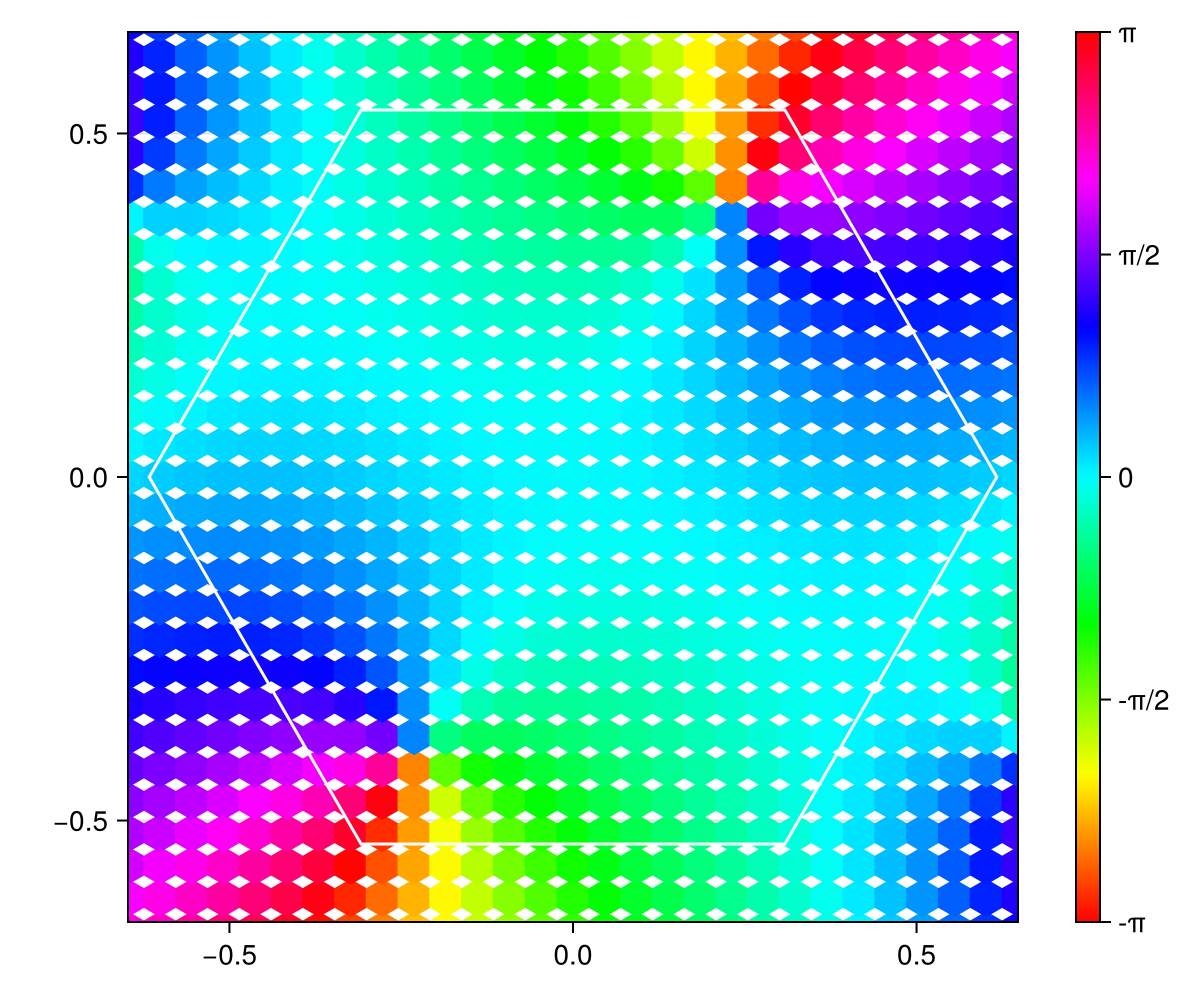

CairoMakie.Screen{IMAGE}


In [31]:
LLHF_plot_phase(ρ_AVL; para=num_para)

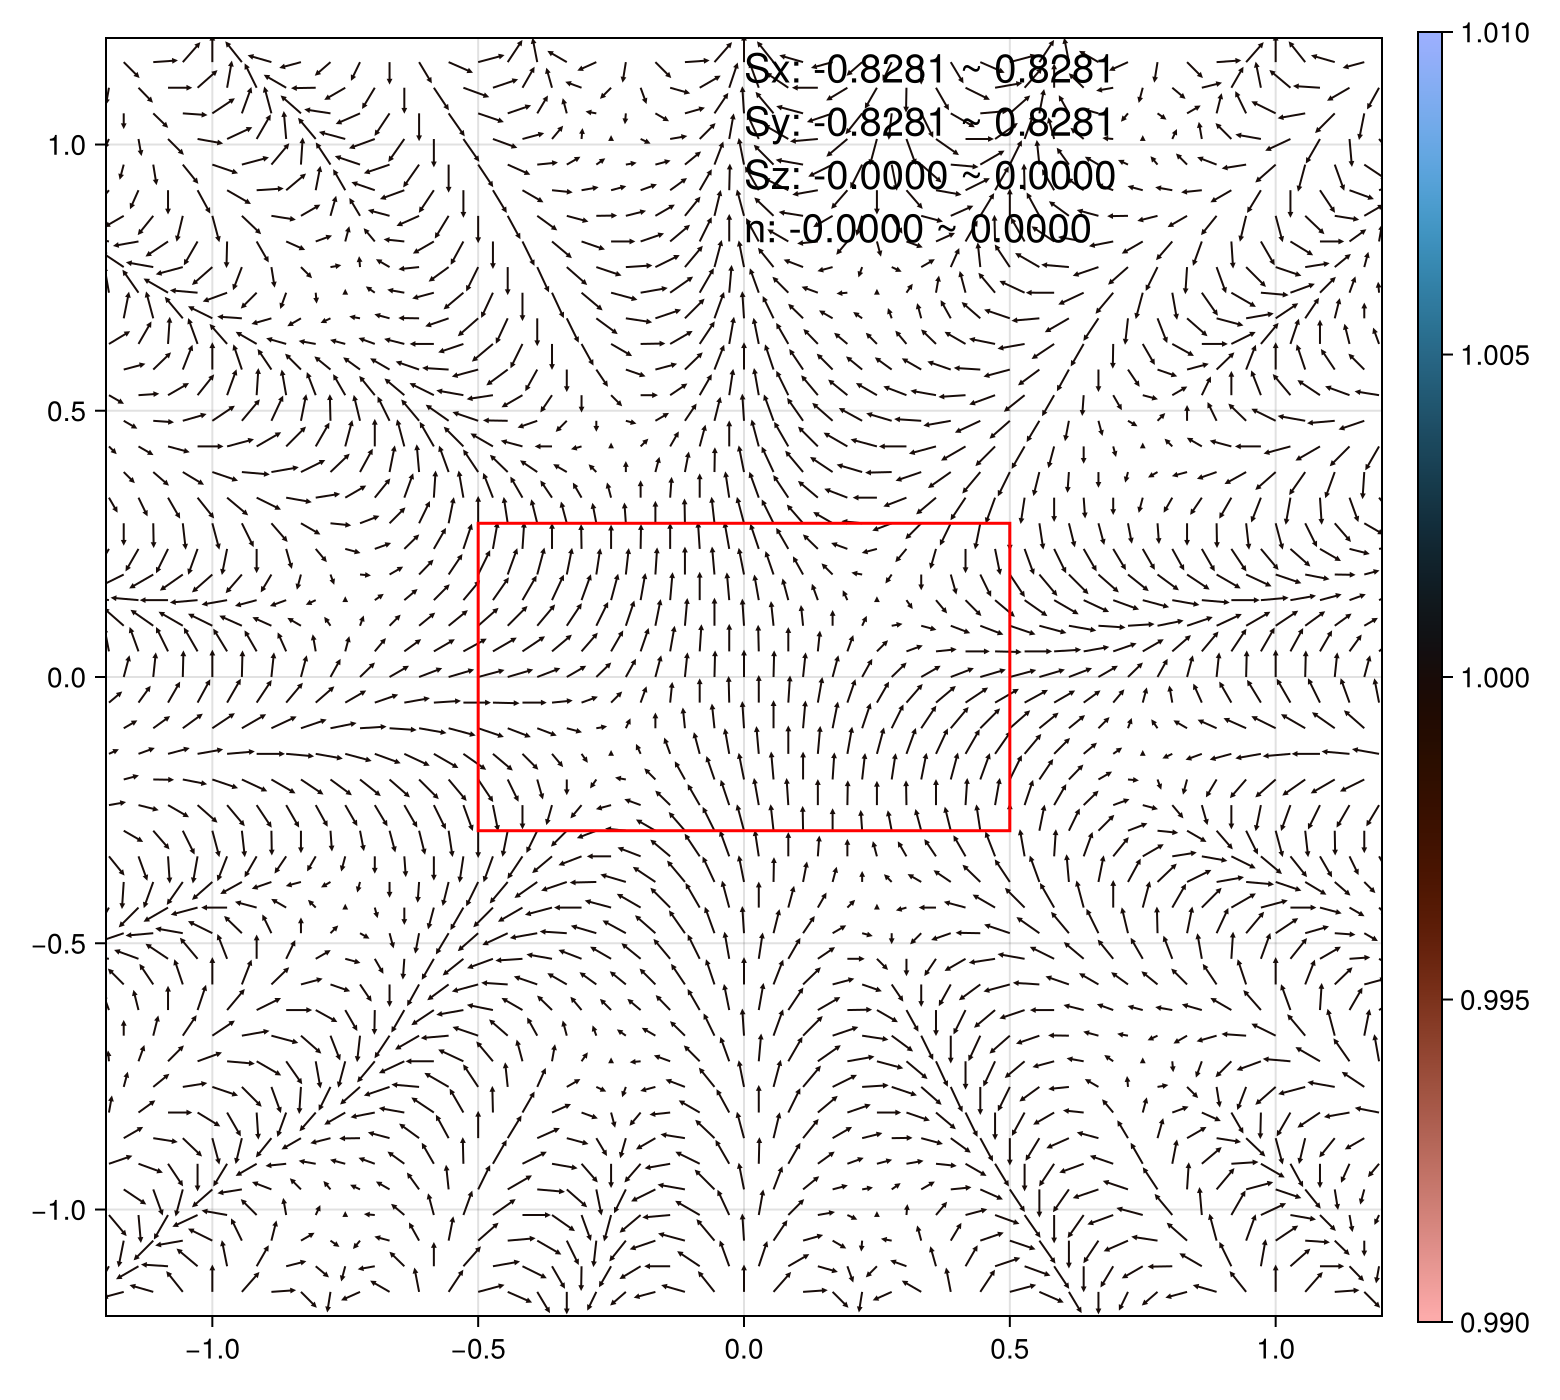

In [32]:
LLHF_plot_realspace(ρ_AVL; para=num_para, arrowcolor = :n,
    N = 18, xlimits = (-1.2, 1.2), ylimits = (-1.2, 1.2), 
    arrowscale = 1, arrowsize = 4
)